In [1]:
import os
import json
from PIL import Image, UnidentifiedImageError

from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchvision import transforms
import torch.optim as optim
from torchvision import models

import glob
import numpy as np
import rasterio

import torch.optim as optim

import matplotlib.pyplot  as plt
from sklearn.metrics import classification_report

import json
import os
import glob

In [7]:

print(torch.cuda.is_available())


True


In [8]:
import json
import os
from torch.utils.data import Dataset
import rasterio
from PIL import Image
import torch
import numpy as np

class TreeSatDatasetGeoJSON(Dataset):
    def __init__(self, geojson_path, aerial_dir, s2_dir, transform_aerial=None, transform_s2=None, split="train"):
        # Load GeoJSON
        with open(geojson_path, 'r') as f:
            geojson = json.load(f)
        
        # Filter features based on split
        self.features = [feature for feature in geojson["features"] if feature["properties"]["SPLIT"] == split]
        
        # Directories for aerial and Sentinel-2 images
        self.aerial_dir = aerial_dir
        self.s2_dir = s2_dir

        # Transformations
        self.transform_aerial = transform_aerial
        self.transform_s2 = transform_s2

        # Label mapping
        self.label_mapping = {"broadleaf": 0, "needleleaf": 1, "cleared": 2}

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        properties = feature["properties"]

        # Image ID
        img_id = properties["IMG_ID"]

        # Load aerial image
        aerial_path = os.path.join(self.aerial_dir, f"{img_id}.tif")
        with rasterio.open(aerial_path) as src:
            aerial_img = src.read([1, 2, 3])  # RGB bands
            aerial_img = np.moveaxis(aerial_img, 0, -1)  # Convert to HWC
            aerial_img = Image.fromarray((aerial_img / 255.0 * 255).astype(np.uint8))  # Normalize
            if self.transform_aerial:
                aerial_img = self.transform_aerial(aerial_img)

        # Load Sentinel-2 image
        s2_path = os.path.join(self.s2_dir, f"{img_id}.tif")
        with rasterio.open(s2_path) as src:
            s2_img = src.read()  # All bands
            s2_img = np.moveaxis(s2_img, 0, -1)  # Convert to HWC
            if self.transform_s2:
                s2_img = self.transform_s2(s2_img)
        s2_img = s2_img.clone().detach().float()


        # Extract label
        label = torch.zeros(len(self.label_mapping))
        l1_label = properties["l1"]  # Use `l1` for high-level classification
        if l1_label in self.label_mapping:
            label[self.label_mapping[l1_label]] = 1

        return aerial_img, s2_img, label


In [9]:
# Transforms for aerial data 
aerial_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Sentinel-2 data normalization
def s2_transform(data):
    # Normalize S2 data to [0, 1] range
    return (data - np.min(data)) / (np.max(data) - np.min(data))



In [10]:
# Aerial model with the pretrained CNN ResNet-18

class AerialModel(nn.Module):
    def __init__(self):
        super(AerialModel, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Identity()  # Remove classification head
        self.fc = nn.Linear(512, 256)  # Map to 256 features

    def forward(self, x):
        x = self.resnet(x)
        x = self.fc(x)
        return x






In [11]:
# S2 model 

class S2Model(nn.Module):
    def __init__(self, input_dim=432, hidden_dim=128):
        super(S2Model, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 64)  # Reduce to 64 features

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x




In [12]:
# Multi-modal model

class FusionModel(nn.Module):
    def __init__(self, num_classes=3):  # Broadleaf, Needleleaf, Cleared
        super(FusionModel, self).__init__()
        self.aerial_model = AerialModel()
        self.s2_model = S2Model(input_dim=6 * 6 * 12)  # Adjust input_dim for Sentinel-2
        self.fc = nn.Linear(256 + 64, num_classes)

    def forward(self, aerial, s2):
        aerial_features = self.aerial_model(aerial)
        s2_features = self.s2_model(s2)
        combined = torch.cat((aerial_features, s2_features), dim=1)
        out = self.fc(combined)
        return out


In [13]:
# Define directories
root_dir = "/home/salyken/TreeSat"
labels_path = os.path.join(root_dir, 'labels', 'TreeSatBA_v9_60m_multi_labels.json')
aerial_dir = os.path.join(root_dir, 'aerial', '60m')
s2_dir = os.path.join(root_dir, 's2', '60m')
geojson_path = os.path.join(root_dir, 'json', 'bb_60m.GeoJSON')

# Transforms
transform_aerial = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

transform_s2 = transforms.Lambda(lambda x: torch.from_numpy(np.transpose(x, (2, 0, 1))))

# Create train and test datasets
train_dataset = TreeSatDatasetGeoJSON(geojson_path, aerial_dir, s2_dir, transform_aerial, transform_s2, split="train")
test_dataset = TreeSatDatasetGeoJSON(geojson_path, aerial_dir, s2_dir, transform_aerial, transform_s2, split="test")

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [14]:
for aerial, s2, label in train_loader:
    print("Aerial Image Shape:", aerial.shape)
    print("S2 Image Shape:", s2.shape)
    print("Label:", label)
    break


Aerial Image Shape: torch.Size([16, 3, 224, 224])
S2 Image Shape: torch.Size([16, 12, 6, 6])
Label: tensor([[1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.]])


In [24]:
from torch.utils.data import Subset

# Create subsets of the train and test datasets
train_subset = Subset(train_dataset, range(5000))
test_subset = Subset(test_dataset, range(5000))

# Verify class balance on the subsets
train_balance = verify_class_balance(train_subset)
test_balance = verify_class_balance(test_subset)

print("Train Dataset Class Distribution:")
print(train_balance)

print("\nTest Dataset Class Distribution:")
print(test_balance)



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:53<00:00, 93.40it/s]

Train Dataset Class Distribution:
{'broadleaf': 2456, 'needleleaf': 2544}

Test Dataset Class Distribution:
{'broadleaf': 2561, 'needleleaf': 2017, 'cleared': 422}


In [15]:
from collections import Counter

def verify_class_balance(dataset):
    class_counts = Counter()

    for idx in tqdm(range(len(dataset))):
        _, _, label = dataset[idx]  # Get the label from the dataset
        class_counts.update(label.nonzero(as_tuple=True)[0].tolist())

    # Map indices back to class names (if applicable)
    if hasattr(dataset.dataset, "label_mapping"):
        idx_to_label = {v: k for k, v in dataset.dataset.label_mapping.items()}
        class_distribution = {idx_to_label[idx]: count for idx, count in class_counts.items()}
    else:
        class_distribution = dict(class_counts)

    return class_distribution


In [16]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [17]:
def save_checkpoint(model, optimizer, epoch, loss, filename="checkpoint.pth"):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss,
    }, filename)
    print(f"Checkpoint saved at epoch {epoch}.")


In [18]:
def load_checkpoint(filename, model, optimizer, scheduler):
    print('hello')
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1  # Start from the next epoch
    return start_epoch, checkpoint['loss']


In [19]:
from torch.optim.lr_scheduler import StepLR

model = FusionModel(num_classes=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


/home/salyken/ml_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/salyken/ml_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [31]:
# Training loop for multi-label classification

epochs = 10

for epoch in range(start_epoch,epochs):
    model.train()
    running_loss = 0.0
    for aerial, s2, labels in tqdm(train_loader):
        aerial, s2, labels = aerial.to(device), s2.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(aerial, s2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    scheduler.step()  # Adjust learning rate
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

    # Save checkpoint
    save_checkpoint(model, optimizer, epoch, running_loss / len(train_loader))




00%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2834/2834 [1:20:15<00:00,  1.70s/it]

Epoch 7, Loss: 0.5250857316073222
Checkpoint saved at epoch 6.



00%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2834/2834 [1:05:22<00:00,  1.38s/it]

Epoch 8, Loss: 0.2112089633026759
Checkpoint saved at epoch 7.



00%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2834/2834 [58:42<00:00,  1.24s/it]

Epoch 9, Loss: 0.1894081383430903
Checkpoint saved at epoch 8.



00%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2834/2834 [55:12<00:00,  1.17s/it]

Epoch 10, Loss: 0.1751958939730569
Checkpoint saved at epoch 9.


In [33]:
# Save model after training
torch.save(model.state_dict(), "fusion_model.pth")

In [20]:
# Reinitialize the model architecture
model = FusionModel(num_classes=3)  # Use the same architecture used during training

# Load the state dictionary
model.load_state_dict(torch.load("fusion_model.pth"))

# Move the model to the appropriate device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


/tmp/ipykernel_755270/3993490315.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fusion_model.pth"))


FusionModel(
  (aerial_model): AerialModel(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1

In [21]:
model.eval()


FusionModel(
  (aerial_model): AerialModel(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1

In [22]:
checkpoint = torch.load("fusion_model.pth")
print(checkpoint.keys())  # See what parameters are saved


/tmp/ipykernel_755270/3722331460.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("fusion_model.pth")


odict_keys(['aerial_model.resnet.conv1.weight', 'aerial_model.resnet.bn1.weight', 'aerial_model.resnet.bn1.bias', 'aerial_model.resnet.bn1.running_mean', 'aerial_model.resnet.bn1.running_var', 'aerial_model.resnet.bn1.num_batches_tracked', 'aerial_model.resnet.layer1.0.conv1.weight', 'aerial_model.resnet.layer1.0.bn1.weight', 'aerial_model.resnet.layer1.0.bn1.bias', 'aerial_model.resnet.layer1.0.bn1.running_mean', 'aerial_model.resnet.layer1.0.bn1.running_var', 'aerial_model.resnet.layer1.0.bn1.num_batches_tracked', 'aerial_model.resnet.layer1.0.conv2.weight', 'aerial_model.resnet.layer1.0.bn2.weight', 'aerial_model.resnet.layer1.0.bn2.bias', 'aerial_model.resnet.layer1.0.bn2.running_mean', 'aerial_model.resnet.layer1.0.bn2.running_var', 'aerial_model.resnet.layer1.0.bn2.num_batches_tracked', 'aerial_model.resnet.layer1.1.conv1.weight', 'aerial_model.resnet.layer1.1.bn1.weight', 'aerial_model.resnet.layer1.1.bn1.bias', 'aerial_model.resnet.layer1.1.bn1.running_mean', 'aerial_model.resn

In [23]:
# Load model
model = FusionModel(num_classes=3)
model.load_state_dict(torch.load("fusion_model.pth"))
model.to(device)
model.eval()

# Perform inference on a single batch
with torch.no_grad():
    for aerial, s2, _ in test_loader:
        aerial, s2 = aerial.to(device), s2.to(device)
        outputs = model(aerial, s2)
        predictions = torch.sigmoid(outputs)  # Convert logits to probabilities
        print(predictions)
        break  # Process one batch


/tmp/ipykernel_755270/1367488395.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fusion_model.pth"))


tensor([[9.9792e-01, 5.7966e-04, 6.1136e-05],
        [9.4403e-01, 6.8653e-02, 6.7198e-04],
        [9.9414e-01, 4.2311e-03, 3.0990e-04],
        [9.9628e-01, 1.1605e-03, 5.6166e-04],
        [9.9028e-01, 6.0970e-03, 1.5430e-03],
        [9.9542e-01, 1.9697e-03, 3.5963e-04],
        [9.9495e-01, 2.4531e-03, 2.6196e-05],
        [9.8714e-01, 5.7880e-03, 1.6377e-03],
        [9.9753e-01, 1.2548e-03, 1.3601e-04],
        [9.9560e-01, 2.1897e-03, 1.8484e-05],
        [5.1472e-03, 9.9253e-01, 2.1728e-04],
        [9.6205e-01, 2.6131e-02, 1.9304e-03],
        [9.9719e-01, 1.4294e-03, 2.4647e-04],
        [9.9166e-01, 5.6490e-03, 2.7479e-04],
        [1.2660e-02, 9.8418e-01, 4.0499e-04],
        [3.9054e-01, 5.6170e-01, 3.0078e-03]], device='cuda:0')


In [34]:
model.eval()
test_loss = 0.0
with torch.no_grad():
    for aerial, s2, labels in tqdm(test_loader):
        aerial, s2, labels = aerial.to(device), s2.to(device), labels.to(device)
        outputs = model(aerial, s2)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
print(f"Test Loss: {test_loss / len(test_loader)}")



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 316/316 [06:56<00:00,  1.32s/it]

Test Loss: 0.18762224082115897


NameError: name 'true_labels' is not defined

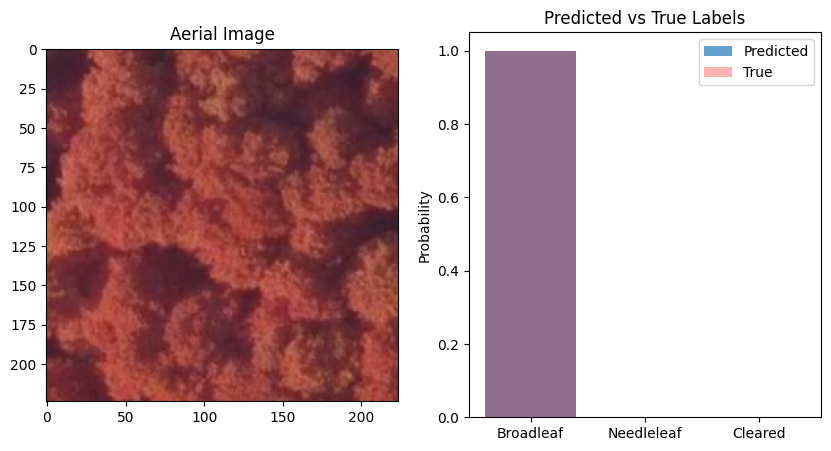

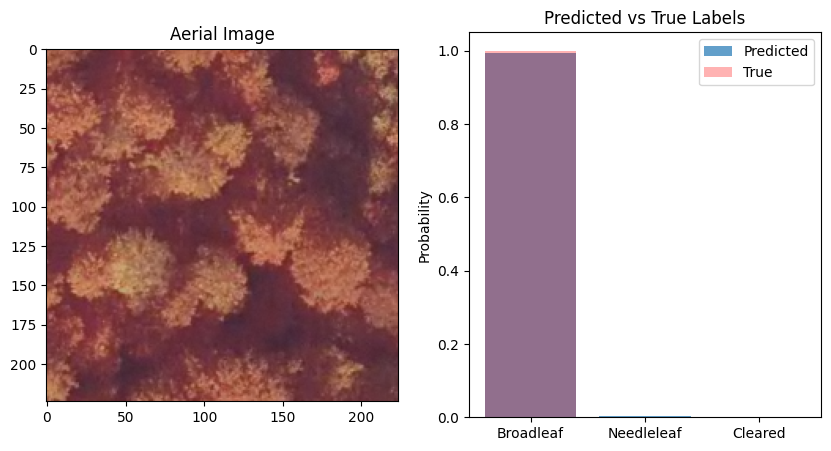

In [54]:

# Define a function to show images and labels
def visualize_results(model, dataloader, device, num_samples=2):
    model.eval()
    
    # Get a batch of data
    for i, (aerial, s2, labels) in enumerate(dataloader):
        if i >= num_samples:  # Limit to a few samples
            break
            
        aerial, s2, labels = aerial.to(device), s2.to(device), labels.to(device)
        
        # Make predictions
        with torch.no_grad():
            outputs = model(aerial, s2)
            predicted_labels = torch.sigmoid(outputs)  # Sigmoid for multi-label classification

        # Convert to NumPy for visualization
        aerial_img = aerial[0].cpu().numpy().transpose(1, 2, 0)  # Convert to HWC format
        predicted_probs = predicted_labels[0].cpu().numpy()  # Convert to CPU for visualization
        true_labels = labels[0].cpu().numpy()

        # Display the image
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(aerial_img)
        plt.title("Aerial Image")

        # Display predicted and true labels
        plt.subplot(1, 2, 2)
        class_names = ["Broadleaf", "Needleleaf", "Cleared"]  # Add all the class names
        plt.bar(class_names, predicted_probs, alpha=0.7, label="Predicted")
        plt.bar(class_names, true_labels, alpha=0.3, label="True", color='r')
        plt.ylabel("Probability")
        plt.title("Predicted vs True Labels")
        plt.legend()
        plt.show()

    

# visualize results
visualize_results(model, test_loader, device)




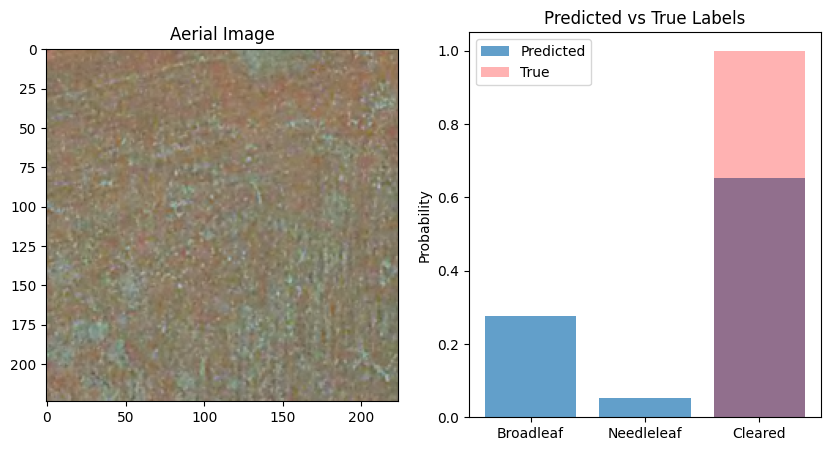

In [38]:
# Visualize a specific image based on index

def visualize_results_for_index(model, dataset, device, index=2004):
    model.eval()

    # Fetch the data for the specific index
    aerial, s2, labels = dataset[index]  

    # Prepare data for the model
    aerial = aerial.unsqueeze(0).to(device)  
    s2 = s2.unsqueeze(0).to(device)
    labels = labels.unsqueeze(0).to(device)

    # Make predictions
    with torch.no_grad():
        outputs = model(aerial, s2)
        predicted_labels = torch.sigmoid(outputs)  

    # Convert data for visualization
    aerial_img = aerial[0].cpu().numpy().transpose(1, 2, 0)  # Convert to HWC format
    predicted_probs = predicted_labels[0].cpu().numpy()  # Predicted probabilities
    true_labels = labels[0].cpu().numpy() 

    # Display the image and the predicted vs true labels
    plt.figure(figsize=(10, 5))

    # Display Aerial Image
    plt.subplot(1, 2, 1)
    plt.imshow(aerial_img)
    plt.title(f"Aerial Image")
    # (Index {index})")

    # Display Predicted vs True Labels
    plt.subplot(1, 2, 2)
    class_names = ["Broadleaf", "Needleleaf", "Cleared"]  # Define your classes
    plt.bar(class_names, predicted_probs, alpha=0.7, label="Predicted")
    plt.bar(class_names, true_labels, alpha=0.3, label="True", color='r')
    plt.ylabel("Probability")
    plt.title("Predicted vs True Labels")
    plt.legend()
    plt.show()

visualize_results_for_index(model, test_dataset, device)


00%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 316/316 [09:07<00:00,  1.73s/it]

True Labels Shape: (5044, 3) Example: [1 0 0]
Pred Labels Shape: (5044, 3) Example: [1 0 0]


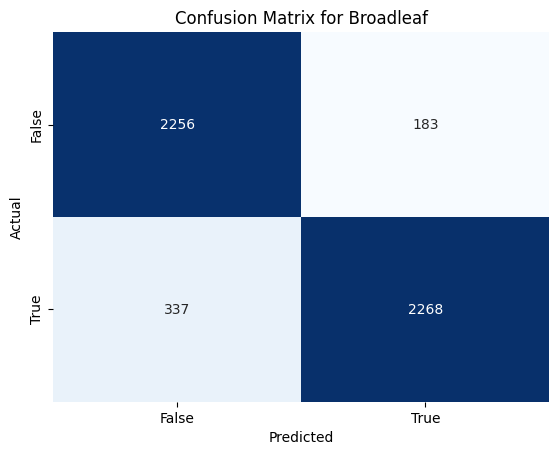

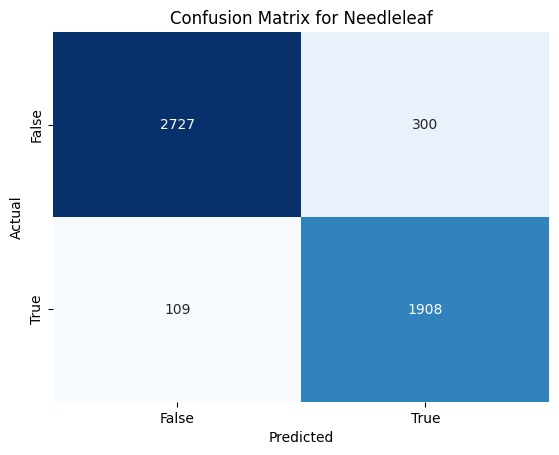

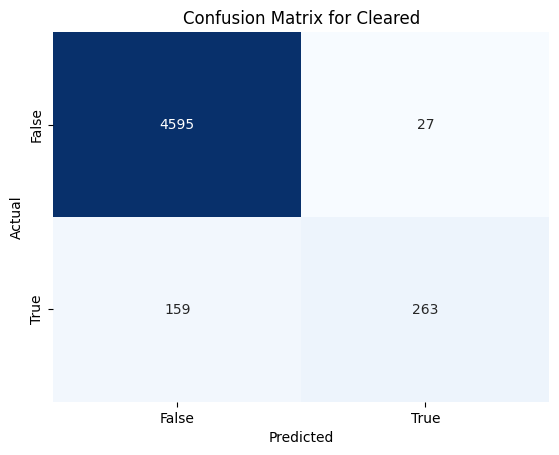

NameError: name 'all_labels' is not defined

In [24]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Perform evaluation
model.eval()
true_labels = []
pred_labels = []

with torch.no_grad():
    for aerial, s2, labels in tqdm(test_loader):
        aerial, s2, labels = aerial.to(device), s2.to(device), labels.to(device)

        # Get predictions
        outputs = model(aerial, s2)
        predictions = torch.sigmoid(outputs)  # Convert logits to probabilities

        # Collect true labels and binary predictions
        true_labels.append(labels.cpu().numpy())  # Already binary
        pred_labels.append((predictions.cpu().numpy() > 0.5).astype(int))  # Threshold at 0.5

# Combine all batches
true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.concatenate(pred_labels, axis=0)

true_labels = true_labels.astype(int)  # Convert true labels to integers
pred_labels = pred_labels.astype(int)  # Convert predicted labels to integers

# Verify shapes and data types
print("True Labels Shape:", true_labels.shape, "Example:", true_labels[0])
print("Pred Labels Shape:", pred_labels.shape, "Example:", pred_labels[0])

# Define class names
class_names = ["Broadleaf", "Needleleaf", "Cleared"]

# Plot confusion matrices
plot_confusion_matrix(true_labels, pred_labels, class_names)


In [36]:
# Generate classification report
from sklearn.metrics import hamming_loss

report = classification_report(true_labels, pred_labels, target_names=["Broadleaf", "Needleleaf", "Cleared"])
accuracy = accuracy_score(true_labels, pred_labels) 
print("Accuracy Score:", accuracy)
print(report)



Hamming Loss: 0.07368490615913297
Accuracy Score: 0.8788659793814433
              precision    recall  f1-score   support

   Broadleaf       0.93      0.87      0.90      2605
  Needleleaf       0.86      0.95      0.90      2017
     Cleared       0.91      0.62      0.74       422

   micro avg       0.90      0.88      0.89      5044
   macro avg       0.90      0.81      0.85      5044
weighted avg       0.90      0.88      0.89      5044
 samples avg       0.88      0.88      0.88      5044



/home/salyken/ml_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


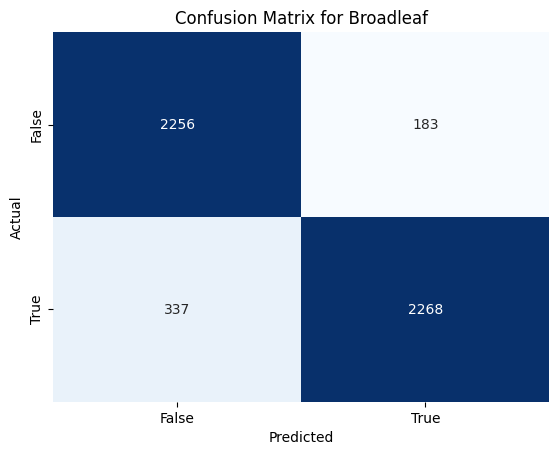

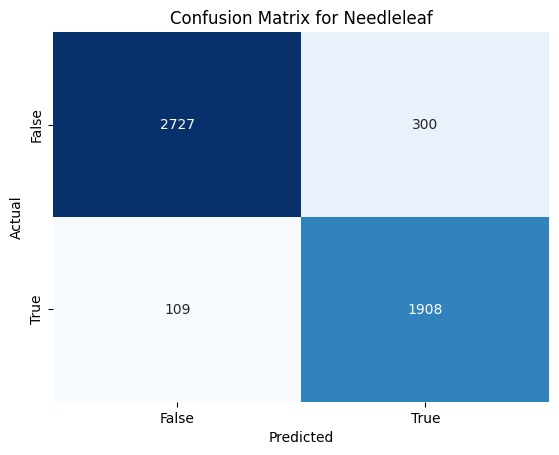

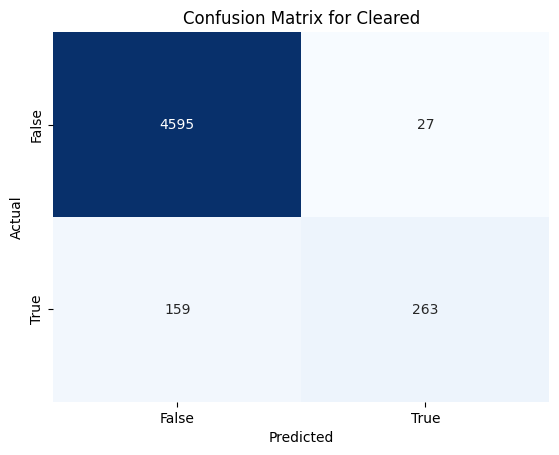

In [30]:
def plot_all_confusion_matrices(y_true, y_pred, labels):
    """Visualize all confusion matrices for multi-label classification in one plot."""
    # Ensure both are in binary format
    y_true = np.array(y_true)  # Convert to NumPy array
    y_pred = np.array(y_pred)  # Convert to NumPy array

    cm = multilabel_confusion_matrix(y_true, y_pred)
    
    num_classes = len(labels)
    cols = 3  # Number of columns for subplots
    rows = (num_classes + cols - 1) // cols  # Compute rows dynamically based on number of classes
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))
    axes = axes.flatten()  # Flatten to easily iterate over
    
    for i, label in enumerate(labels):
        sns.heatmap(cm[i], annot=True, fmt="d", cmap="Blues", cbar=False,
                    xticklabels=["False", "True"],
                    yticklabels=["False", "True"],
                    ax=axes[i])
        axes[i].set_title(f"Confusion Matrix: {label}")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("Actual")
    
    # Remove any empty subplots
    for j in range(len(labels), len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()


# Plot confusion matrices
plot_confusion_matrix(true_labels, pred_labels, class_names)

In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, hamming_loss

# Different evaluation metrics
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')
accuracy = accuracy_score(true_labels, pred_labels)


print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")


Precision: 0.8993
Recall: 0.8801
F1 Score: 0.8863
Accuracy: 0.8789
Hamming Loss: 0.0737



00%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 316/316 [06:00<00:00,  1.14s/it]

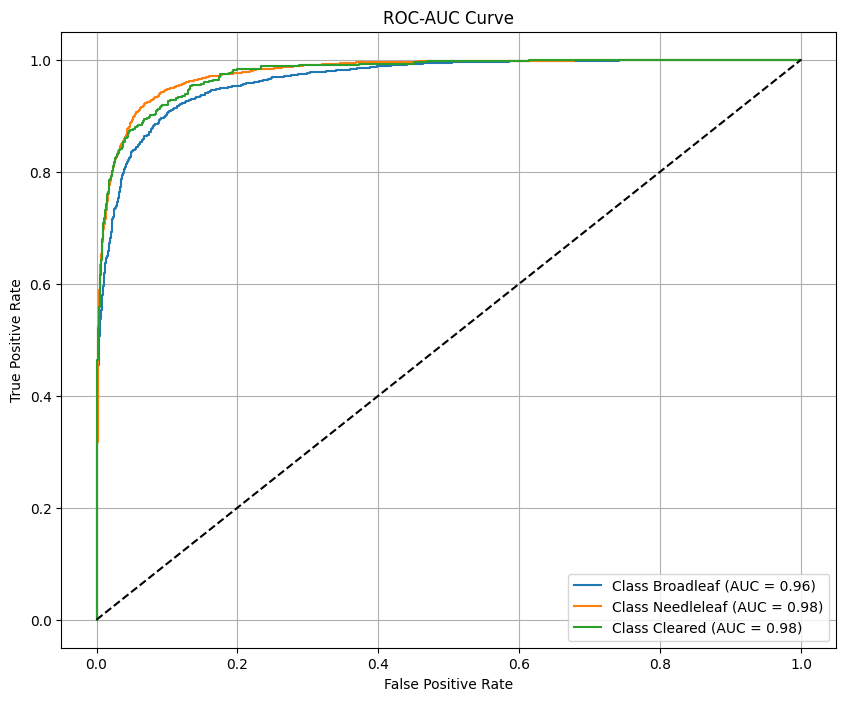

In [70]:
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np

#PLot ROC-curve
def plot_roc_auc(model, dataloader, device, true_labels, pred_labels, num_classes=3):

    class_names = ["Broadleaf", "Needleleaf", "Cleared"]
    
    # Plot ROC-AUC for each class
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(class_names):
        fpr, tpr, _ = roc_curve(true_labels[:, i], pred_labels[:, i])
        auc = roc_auc_score(true_labels[:, i], pred_labels[:, i])
        plt.plot(fpr, tpr, label=f"Class {label} (AUC = {auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--")  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-AUC Curve")
    plt.legend()
    plt.grid()
    plt.show()


plot_roc_auc(model, test_loader, true_labels, pred_labels, device)
